In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [8]:
%matplotlib inline

import pandas as pd
from aeps import AEP_metrics_lims
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from spiketrain import inst_rate
from population import unit_response_matrix, spontaneous_activity

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [54]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/reporting'

#sessions = [s for s in selected_009265.keys()]
sessions = [s for s in selected_009266.keys()]
sessions.sort()
#selected = sessions[:2] + sessions[5:]
selected = sessions[:]
selected.remove('009266_hippoSIT_2023-04-20_15-24-14')  # only one A1 unit
#selected

In [61]:
session = selected[-3]
session

'009266_hippoSIT_2023-05-25_15-55-57'

In [62]:
# read AEPs- and meta- data
animal      = session.split('_')[0]
meta_file   = os.path.join(dst_path, animal, session, 'meta.h5')
units_file  = os.path.join(dst_path, animal, session, 'units.h5')
aeps_c_file = os.path.join(dst_path, animal, session, 'analysis', 'AEP_components.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])

single_units, spike_times = {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [63]:
# compute spontaneous activity
s_path = os.path.join(dst_path, animal, session)
spont_act  = spontaneous_activity(s_path)

sos = signal.butter(10, 0.01, fs=4, analog=False, btype='highpass', output='sos')
spont_act = signal.sosfiltfilt(sos, spont_act)

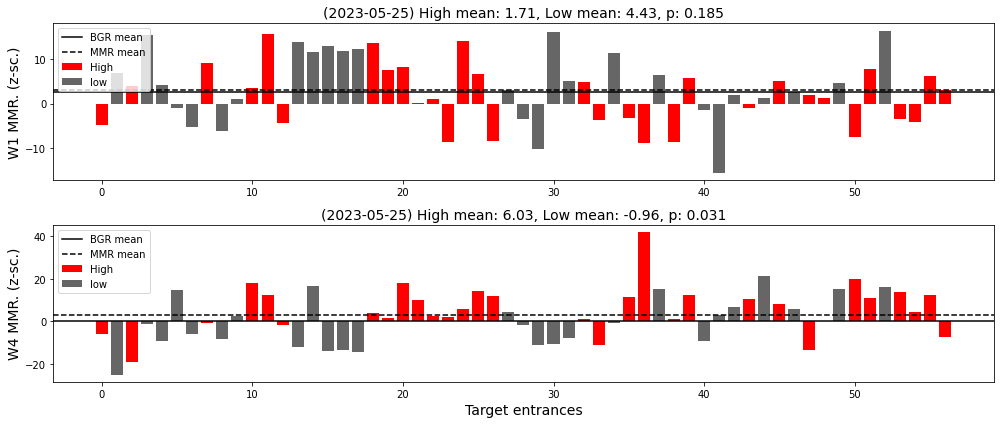

In [64]:
MMR_mx = np.zeros([len(tgt_mx), 4])

idxs_high = np.where(spont_act[tgt_mx[:, 0] - 1] > spont_act.mean())[0]
idxs_low  = np.where(spont_act[tgt_mx[:, 0] - 1] < spont_act.mean())[0]

colors = ['blue', 'red', 'green', 'black']
phase_idxs = [1, 4]
rows = len(phase_idxs)
fig, axes = plt.subplots(rows, 1, figsize=(14, 3*rows))
for i, idx in enumerate(phase_idxs):
    bins, unit_mx = unit_response_matrix(s_path, [1, 2])
    resp_at_phase = unit_mx[idx::5]
    unit_act_matrix = resp_at_phase.T
    for u, unit_data in enumerate(unit_act_matrix):
        unit_act_matrix[u] = stats.zscore(unit_data)
    resp_at_phase = unit_act_matrix.T
    pop_act  = resp_at_phase.sum(axis=1)  # one way
    
    BGR_mean = pop_act[sound_events[:, 1] == 1].mean()
    MMR_resp = pop_act[tgt_mx[:, 0]] - BGR_mean
    MMR_mean = (pop_act[tgt_mx[:, 0]] - BGR_mean).mean()
    res = stats.ttest_ind(MMR_resp[idxs_high], MMR_resp[idxs_low])

    ax = axes[i]
    ax.bar(idxs_high, MMR_resp[idxs_high], color='red', label='High')
    ax.bar(idxs_low, MMR_resp[idxs_low], color='black', alpha=0.6, label='low')
    ax.axhline(BGR_mean, color='black', label="BGR mean")
    ax.axhline(MMR_mean, color='black', ls='--', label="MMR mean")
    if i == len(phase_idxs) - 1:
        ax.set_xlabel('Target entrances', fontsize=14)
    ax.set_title('(%s) High mean: %.2f, Low mean: %.2f, p: %.3f' % (
        session[-19:-9], MMR_resp[idxs_high].mean(), MMR_resp[idxs_low].mean(), res.pvalue
    ), fontsize=14)
    ax.set_ylabel('W%s MMR. (z-sc.)' % str(idx), fontsize=14)
    ax.legend(loc='upper left')
    
fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_MMR.png' % session[-19:-9]), dpi=1000)

In [79]:
for r1 in MMR_mx.T:
    #for r2 in MMR_mx.T:
    print(stats.pearsonr(r1, pop_act_filt[tgt_mx[:, 2] - 300]))
        

(-0.1477409115361164, 0.2155334967401705)
(0.0170097258753431, 0.8872249434661957)
(0.12195254225594712, 0.307488415351175)
(-0.1701934027501542, 0.15291355803897788)


In [80]:
# need to compute MMR taking into account PCA WEIGHTS for the population!! 
# otherwise inhibition and excitation are summed up looks like